In [592]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [593]:
import numpy as np
from matplotlib import pyplot as plt

from src.channel_blocks import ChannelBlocks
from src.channel_simulation import ChannelSimulator
from src.split_step_fourier import SplitStepFourier
from src.visualizer import Visualizer
from src.signal_processing import SP

# Channel Simulation
here starts the actual channel simulator code.

In [594]:
modify_t0 = 1e0
modify_zn = 1e0
modify_h = 1e0
modify_au = 1

dt = 1  # 1e-12

test_verbose = False

cs = ChannelSimulator(m_qam=16,
                      num_symbols=512,
                      normalization_factor=1e-3 * modify_au,
                      dt=dt,
                      channel_func=SplitStepFourier(
                          alpha=0,
                          b2=-20e-27,
                          gamma=0.003,
                          t0=125e-12 * modify_t0,
                          dt=dt,
                          z_n=1 * modify_zn,
                          h=500 * modify_h
                      ),
                      verbose=True)

np.set_printoptions(threshold=250)

number of iterations in split step algo: 1562


In [595]:
cs.step0_gen_msg()  # generate message


_______________________________________________
message before channel - len=2048
[[1 0 1 0]
 [0 1 0 1]
 [0 0 0 1]
 ...
 [0 1 0 0]
 [0 1 1 0]
 [1 1 1 0]]


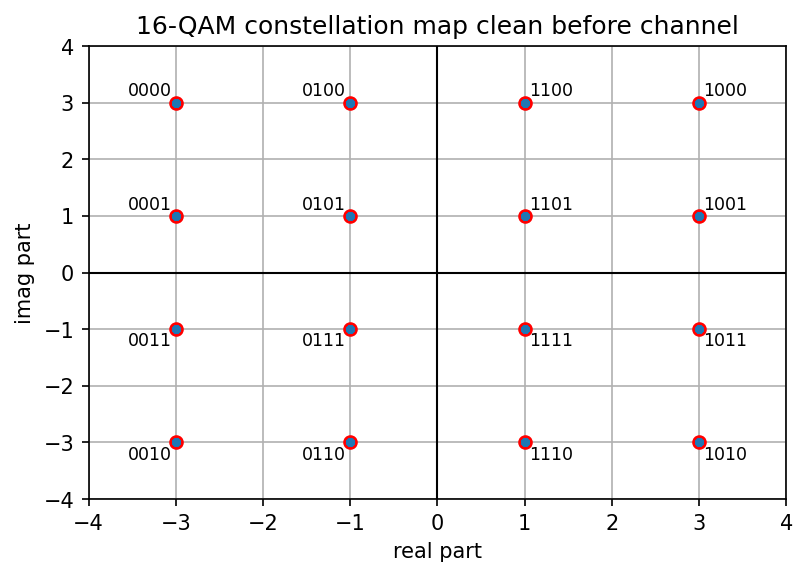

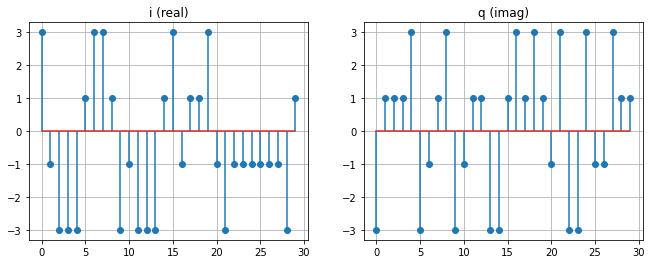

num of symbols = 512


In [596]:
cs.step1_modulate()  # modulate

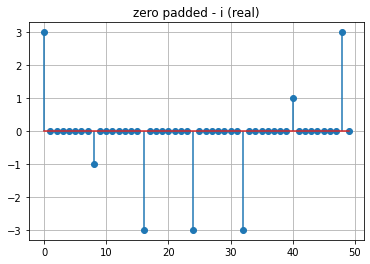

vec length = 4096, over_sampling period = 8


In [597]:
cs.step2_over_sample()  # over sample

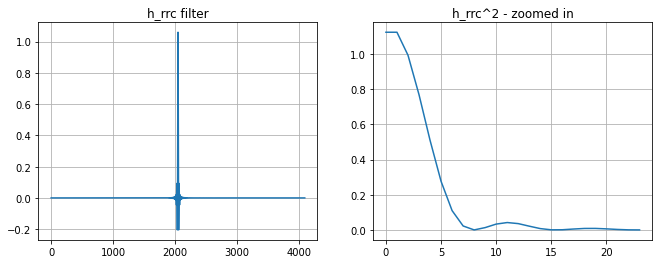

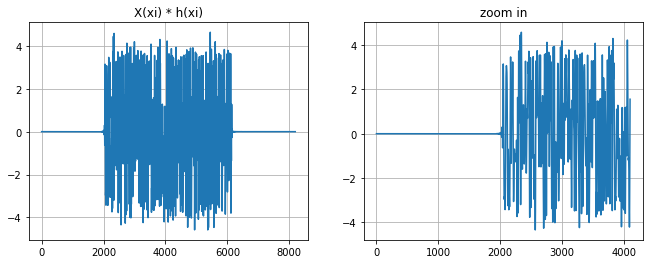

filter len = 4097, signal len = 8192


In [598]:
cs.step3_pulse_shaping()  # pulse shaping

xi ∈ [-0.00:0.00] GHz ,	 N_xi   (=M) = 8192
t  ∈ [-4096000000000000.00:4095000000000000.00] ps    ,	 N_time (=D) = 8192
BW = 0.00 GHz


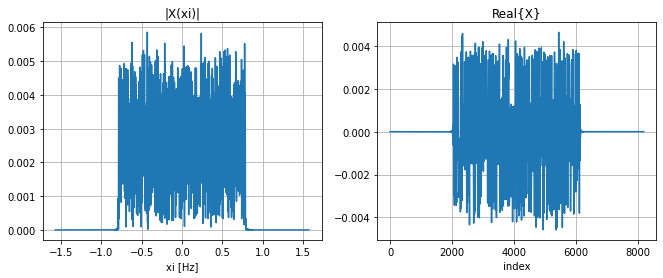

signal len = 8192


In [599]:
cs.step4_pre_equalize()  # pre equalize (equalize before inft)

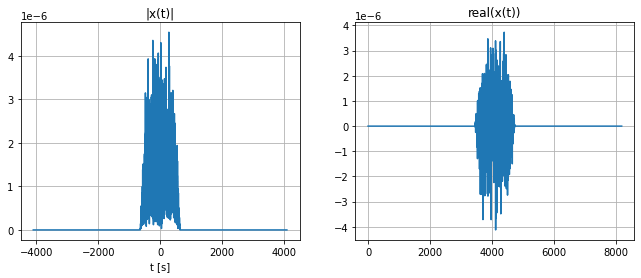

length of INFT(x) = 8192
signal power = 5.55e-05
signal bw = [-6.31e+02:6.36e+02]


In [600]:
cs.step5_inft()  # inft

In [601]:
# backup_x5 = cs.x[5].copy()
# Visualizer.print_signal_specs(backup_x5,cs.tvec)

In [602]:
# equalize before channel
# cs.x[5] = backup_x5 * 1e-9
#
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))
# Visualizer.my_plot(cs.tvec, np.abs(cs.x[5]), name=f'|x(t)|', xlabel='t [s]', ax=ax1,
#                    hold=1)
# Visualizer.my_plot(np.real(cs.x[5]), name=f'real(x(t))', ax=ax2)
# print(f'length of INFT(x) = {len(cs.x[5])}')
#
# th = np.max(np.abs(cs.x[5])) * 0.01
# Visualizer.print_signal_specs(cs.x[5], cs.tvec, th)

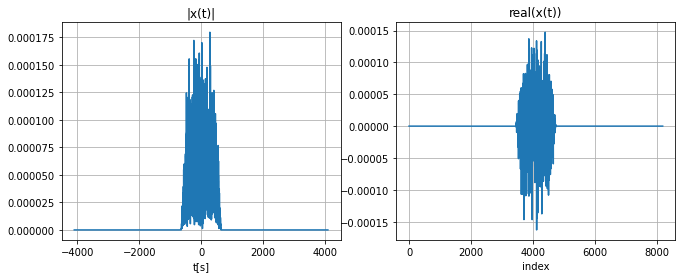

In [603]:
cs.step6_channel()  # channel (ssf)

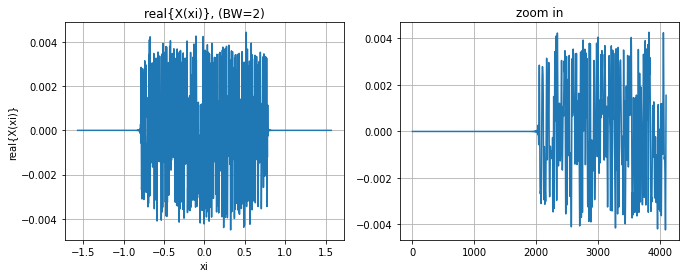

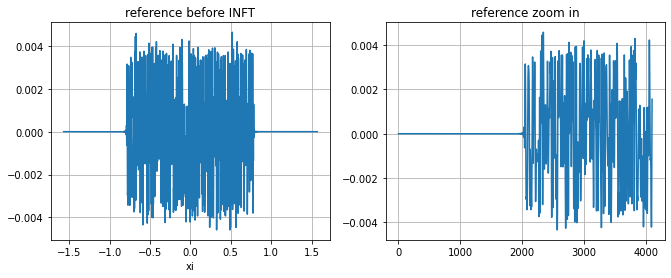

In [604]:
# cs.x[6] *= 1e11
cs.step7_nft()  # nft

In [605]:
cs.step8_equalize()  # equalizer

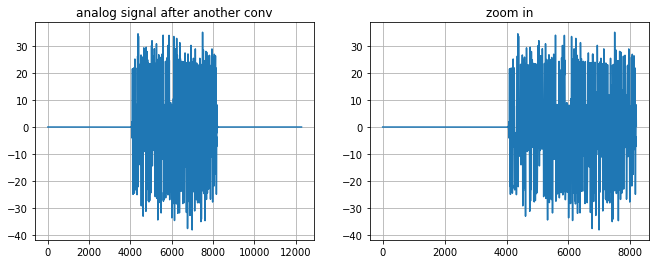

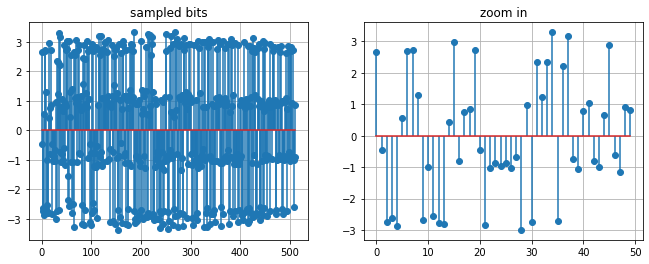

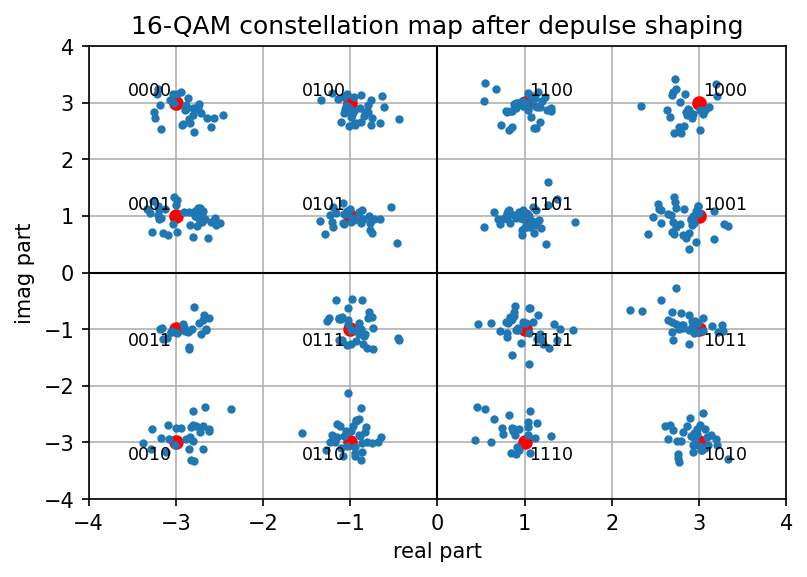

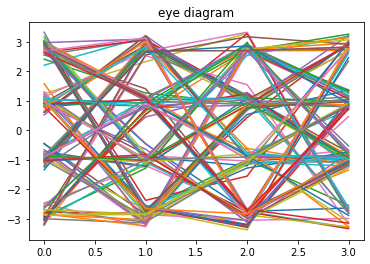

num of sampled symbols = 512 


In [606]:
cs.step9_match_filter()  # match filter

In [607]:
cs.step10_demodulate()  # demod()


_______________________________________________
message after channel - len=2048
[[1 0 1 0]
 [0 1 0 1]
 [0 0 0 1]
 ...
 [0 1 0 0]
 [0 1 1 0]
 [1 1 1 0]]


In [608]:
ber, num_errors = cs.evaluate()

ber = 0.0 = 0/2048
